# ESGF Virtual Aggregation - Demo

Remote data access to Virtual Analysis Ready Data (Virtual ARD) for climate datasets of the [ESGF](https://esgf.llnl.gov/).

## Contents

* [Introduction](#introduction)
  * [Loading the inventory](#loading-the-inventory)
  * [Loading a dataset](#loading-a-dataset)
  * [Query attributes](#query-attributes)
  * [Performing data analysis](#performing-data-analysis)
* [Discussion](#discussion)

In [1]:
import numpy as np
import pandas as pd
import xarray
import dask
import cartopy.crs as ccrs

dask.config.set(scheduler="processes")

# Introduction <a class="anchor" id="introduction"></a>

## Loading the inventory <a class="anchor" id="loading-the-inventory"></a>

Currently, the invetory is a CSV file which can be queried for locating the desired dataset. Note that there are two different types of aggreations:

- Dataset aggregation - The time series of a variable is concatenated along the time dimension (aka "CMIP6 dataset").
- Ensemble aggregation - The time series of a variable is concatenated along the time dimension and a new dimension is added for the different ensemble members of a model.

In [2]:
df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/inventory.csv")

# Find a dataset
subset = df.query("aggregation == 'ensemble' & product == 'ScenarioMIP' & model == 'CNRM-CM6-1' & experiment == 'ssp245' & table == 'day' & variable == 'tas' & version == 'v20190410'")

# See available data nodes
subset[["location", "data_node"]]

/tmp/ipykernel_261328/3547712982.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/inventory.csv")


,location,data_node
211768,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esg1.umr-cnrm.fr
211774,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,aims3.llnl.gov
211780,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.ceda.ac.uk
211784,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.nci.org.au
211788,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf3.dkrz.de


Once you have located the desired URL for your dataset, save its URL.

In [3]:
# Select a data node and get the url
url = subset.query("data_node == 'aims3.llnl.gov'")["location"].iloc[0]

## Loading a dataset <a class="anchor" id="loadingg-a-dataset"></a>

Now that you have an URL, try to load the dataset using [xarray](https://docs.xarray.dev/en/stable/).

In [4]:
# Use a demo URL for demonstration (see https://hub.ipcc.ifca.es/thredds/catalog/esgeva/demo/catalog.html)
url = "https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/demo/CMIP6_ScenarioMIP_MIROC_MIROC-ES2L_ssp245_3hr_tas_gn_v20210107_esgf-data02.diasjp.net.ncml"

# Load the URL
ds = xarray.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:           (lat: 64, bnds: 2, lon: 128, time: 251288,
                       variant_label: 29, nfiles: 2494, file: 2)
Coordinates:
  * lat               (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon               (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height            float64 ...
  * time              (time) datetime64[ns] 2015-01-01T03:00:00 ... 2101-01-01
  * variant_label     (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Dimensions without coordinates: bnds, nfiles, file
Data variables:
    lat_bnds          (lat, bnds) float64 ...
    lon_bnds          (lon, bnds) float64 ...
    further_info_url  (nfiles, file) |S64 ...
    tracking_id       (nfiles, file) |S64 ...
    tas               (variant_label, time, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:            
    activity_id:            ScenarioMIP
    branch_method:          no parent
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          
    ...                     ...
    size:                   2147483647
    size_human:             129.5 GiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    version:                v20210107
    replica:                0

### Query attributes <a class="anchor" id="query-attributes"></a>

The ESGF Virtual Aggregation includes metadata of interest for the users. Let's inspect some attributes.

In [5]:
# Query the size of the dataset on the server side (sum of file sizes on the server
ds.attrs["size_human"] # Note that this might be different from the size in memory

'129.5 GiB'

In [6]:
# View the variant_label (ensemble) coordinate
ds["variant_label"][...]

<xarray.DataArray 'variant_label' (variant_label: 29)>
array([b'r10i1p1f2', b'r11i1p1f2', b'r12i1p1f2', b'r13i1p1f2', b'r14i1p1f2',
       b'r15i1p1f2', b'r16i1p1f2', b'r17i1p1f2', b'r18i1p1f2', b'r19i1p1f2',
       b'r20i1p1f2', b'r21i1p1f2', b'r22i1p1f2', b'r23i1p1f2', b'r24i1p1f2',
       b'r25i1p1f2', b'r26i1p1f2', b'r27i1p1f2', b'r28i1p1f2', b'r29i1p1f2',
       b'r2i1p1f2', b'r30i1p1f2', b'r3i1p1f2', b'r4i1p1f2', b'r5i1p1f2',
       b'r6i1p1f2', b'r7i1p1f2', b'r8i1p1f2', b'r9i1p1f2'], dtype='|S64')
Coordinates:
    height         float64 ...
  * variant_label  (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Attributes:
    standard_name:        realization
    _CoordinateAxisType:  Ensemble

In [7]:
# Query the PID handles of the virtual dataset
ds["tracking_id"][:,1].values

array([b'hdl:21.14100/f79f6918-0a37-48c4-b30a-2c4ec9a4cb83',
       b'hdl:21.14100/971fe141-679e-4eb3-b196-7964ec6767f9',
       b'hdl:21.14100/b5ee8254-2b90-4c54-b044-07482009788f', ...,
       b'hdl:21.14100/94e4cf10-6dbf-4397-8fba-ac100d0b5435',
       b'hdl:21.14100/52d91e1d-8850-48a4-b2c0-4e89475dd5c9',
       b'hdl:21.14100/816e6917-15f5-4e83-9770-cad1679ba004'], dtype='|S64')

## Performing data analysis <a class="anchor" id="performing-data-analysis"></a>

Now that we have loaded the dataset, we can perform data analysis on it. First, let's chunk the dataset to allow scalability through [Dask]().

In [8]:
dsc = ds.chunk({"variant_label":1, "time": 100})

Now, inspect the structure of the data cube.

In [9]:
dsc["tas"]

<xarray.DataArray 'tas' (variant_label: 29, time: 251288, lat: 64, lon: 128)>
dask.array<xarray-tas, shape=(29, 251288, 64, 128), dtype=float32, chunksize=(1, 100, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon            (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height         float64 ...
  * time           (time) datetime64[ns] 2015-01-01T03:00:00 ... 2101-01-01
  * variant_label  (variant_label) |S64 b'r10i1p1f2' ... b'r9i1p1f2'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: mean time: point
    cell_measures:    area: areacella
    history:          2020-11-28T05:25:09Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  64 128]

We are ready to perform data analysis of an small subset of the array and plot the results. Note that only the required data is transferred through the networking, involving no file downloads at all.

In [10]:
bins = [
    np.datetime64('2100-01-01'),
    np.datetime64('2100-03-15'),
    np.datetime64('2100-06-15'),
    np.datetime64('2100-09-15'),
    np.datetime64('2100-12-31')]
da = dsc["tas"].sel(variant_label=[b"r10i1p1f2", b"r11i1p1f2"], time=slice("21000101", None))

In [11]:
da

<xarray.DataArray 'tas' (variant_label: 2, time: 2921, lat: 64, lon: 128)>
dask.array<getitem, shape=(2, 2921, 64, 128), dtype=float32, chunksize=(1, 100, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon            (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height         float64 ...
  * time           (time) datetime64[ns] 2100-01-01 ... 2101-01-01
  * variant_label  (variant_label) |S64 b'r10i1p1f2' b'r11i1p1f2'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: mean time: point
    cell_measures:    area: areacella
    history:          2020-11-28T05:25:09Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  64 128]

In [12]:
%time results = da.groupby_bins("time", bins).mean().compute(nworkers=4)

CPU times: user 280 ms, sys: 47.7 ms, total: 328 ms
Wall time: 18 s


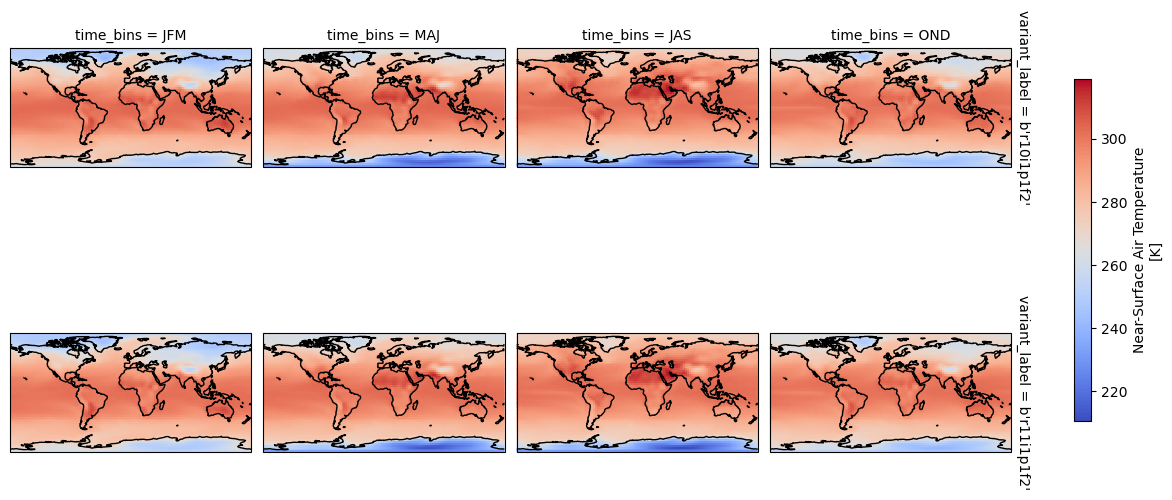

In [13]:
plot = results.assign_coords({"time_bins": ["JFM", "MAJ", "JAS", "OND"]}).plot(
    x="lon", y="lat", col="time_bins", row="variant_label",
    #figsize=(20,6),
    add_colorbar=True,
    cmap="coolwarm",
    cbar_kwargs={"shrink": .6},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

# Discussion <a class="anchor" id="discussion"></a>

## How it works?

**ALL** ESGF file metada is queried into a local database and from this database, small metadata [NcML]() files are created. The NcML files allow to merge multiple netCDF files into a single dataset. netCDF files from the federation are referenced by their OPeNDAP endpoint, thus no data movement is needed from the original data nodes.

```xml
<aggregation type="joinNew" dimName="variant_label">
    <variableAgg name="tas" />
        <netcdf coordValue="r2i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r2i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r2i1p1f2_gr_20150101-21001231.nc" ncoords="31411"></variable></netcdf>
            </aggregation>
        </netcdf>
        <netcdf coordValue="r3i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r3i1p1f2_gr_20150101-21001231.nc" ncoords="31411"></variable></netcdf>
            </aggregation>
        </netcdf>
</aggregation>
```

## How does ESGF Virtual Aggregation compare to cloud repositories like CMIP6 from Pangeo?

People from Pangeo are setting up cloud repositories for CMIP6 ARCO (Analysis Ready Cloud Optimized) datasets from ESGF. While the performance of these repositories is much superior to the data nodes of the ESGF, the cost of implementing these repositories is huge, due to the cost of duplicating the data. The ESGF Virtual Aggregation is less performant than cloud repositories but it is also much cheaper to build.

The ESGF Virtual Aggregation should be seen as an intermediate approach between the current state of the ESGF federation and more ground-breaking solutions like cloud repositories. Its main purpose is to show the compute capabilites that can be reached building on top of the existing federation.

## How does OPeNDAP compare to Zarr for remote data analysis?

In summary, Zarr is more efficient for remote data analysis, because when requesting a piece of data from a Zarr store, the chunks travel compressed to the client. On the other hand, OPeNDAP servers uncompress the chunks from netCDF files on the server and send the data uncompressed to the client, making the transfer more inefficient.

## Does OPeNDAP scale?

OPeNDAP is provided by the [THREDDS Data Server]() in ESGF data nodes. The TDS is a java web application and its ability to scale is the same as any other java web application. If deployed in a single application server, scalibility is limited to the single machine. If a kubernetes clustes is available to spawm multiple application servers, then it can scale and provide more performance.